# Deep Deterministic Policy Gradient (DDPG)
### Solving `Pendulum-v1` Problem
> Deep RL course - Fall 2024 - Sharif University of Technology - Workshop session <br>
> Author: M Narimani - December 22nd, 2024 <br>

In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model, layers
from datetime import datetime
from collections import deque
import random

In [2]:
print("TensorFlow %s" % tf.__version__)
print("gym %s" % gym.__version__)
print("numpy %s" % np.__version__)

TensorFlow 2.10.0
gym 0.26.0
numpy 1.23.0


## DDPG Algorithm

<center>
<img src="ddpg_dong.png" alt="DDPG Dong et al." width=500/>
</center>

In [3]:
class Actor(Model):
    def __init__(self, action_dim, action_max, hidden_sizes=(300,)):
        super(Actor, self).__init__()
        self.action_max = action_max
        self.hidden_layers = []
        
        # Create hidden layers
        for h in hidden_sizes:
            self.hidden_layers.append(layers.Dense(h, activation='relu'))
            
        # Output layer
        self.output_layer = layers.Dense(action_dim, activation='tanh')
        
    def call(self, state):
        x = state
        for layer in self.hidden_layers:
            x = layer(x)
        return self.action_max * self.output_layer(x)

In [4]:
class Critic(Model):
    def __init__(self, hidden_sizes=(300,)):
        super(Critic, self).__init__()
        self.hidden_layers = []
        
        # Create hidden layers
        for h in hidden_sizes:
            self.hidden_layers.append(layers.Dense(h, activation='relu'))
            
        # Output layer (Q-value)
        self.output_layer = layers.Dense(1)
        
    def call(self, inputs):
        state, action = inputs
        x = tf.concat([state, action], axis=-1)
        for layer in self.hidden_layers:
            x = layer(x)
        return tf.squeeze(self.output_layer(x), axis=1)

In [5]:
class ReplayBuffer:
    def __init__(self, obs_dim, act_dim, size):
        self.memory = deque(maxlen=size)
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        
    def store(self, obs, act, rew, next_obs, done):
        self.memory.append((obs, act, rew, next_obs, done))
        
    def sample_batch(self, batch_size=32):
        batch = random.sample(self.memory, min(batch_size, len(self.memory)))
        
        # Convert batch of tuples to tuple of batches
        s_batch, a_batch, r_batch, s2_batch, d_batch = zip(*batch)
        
        return dict(
            s=np.array(s_batch, dtype=np.float32),
            s2=np.array(s2_batch, dtype=np.float32),
            a=np.array(a_batch, dtype=np.float32),
            r=np.array(r_batch, dtype=np.float32),
            d=np.array(d_batch, dtype=np.float32)
        )
    
    @property
    def size(self):
        return len(self.memory)

In [6]:
class DDPG:
    def __init__(
        self,
        env,
        hidden_sizes=(300,),
        start_steps=1e4,
        replay_size=int(1e4),
        batch_size=100,
        gamma=0.99,
        decay=0.995,
        mu_lr=1e-3,
        q_lr=1e-3,
        action_noise=0.1,
        max_episode_length=200
    ):
        self.env = env
        self.gamma = gamma
        self.decay = decay
        self.batch_size = batch_size
        self.action_noise = action_noise
        self.start_steps = start_steps
        self.max_episode_length = max_episode_length
        
        # Extract environment dimensions
        self.num_states = self.env.observation_space.shape[0]
        self.num_actions = self.env.action_space.shape[0]
        self.action_max = self.env.action_space.high[0]
        
        # Create networks
        self.actor = Actor(self.num_actions, self.action_max, hidden_sizes)
        self.critic = Critic(hidden_sizes)
        self.target_actor = Actor(self.num_actions, self.action_max, hidden_sizes)
        self.target_critic = Critic(hidden_sizes)
        
        # Build networks (initialize weights)
        dummy_state = tf.zeros([1, self.num_states])
        dummy_action = tf.zeros([1, self.num_actions])
        self.actor(dummy_state)
        self.critic([dummy_state, dummy_action])
        self.target_actor(dummy_state)
        self.target_critic([dummy_state, dummy_action])
        
        # Copy weights to target networks
        self.target_actor.set_weights(self.actor.get_weights())
        self.target_critic.set_weights(self.critic.get_weights())
        
        # Create optimizers
        self.actor_optimizer = tf.keras.optimizers.Adam(mu_lr)
        self.critic_optimizer = tf.keras.optimizers.Adam(q_lr)
        
        # Create replay buffer
        self.replay_buffer = ReplayBuffer(self.num_states, self.num_actions, replay_size)
        
    def get_action(self, s, noise_scale):
        a = self.actor(tf.convert_to_tensor(s.reshape(1,-1), dtype=tf.float32))
        a = a.numpy()[0]  # Convert to numpy array
        a += noise_scale * np.random.randn(self.num_actions)
        return np.clip(a, -self.action_max, self.action_max)
    
    @tf.function
    def update(self, batch):
        states = tf.convert_to_tensor(batch['s'], dtype=tf.float32)
        states_next = tf.convert_to_tensor(batch['s2'], dtype=tf.float32)
        actions = tf.convert_to_tensor(batch['a'], dtype=tf.float32)
        rewards = tf.convert_to_tensor(batch['r'], dtype=tf.float32)
        dones = tf.convert_to_tensor(batch['d'], dtype=tf.float32)
        
        # Update critic
        with tf.GradientTape() as tape:
            # Target actions
            target_actions = self.target_actor(states_next)
            
            # Target Q-values
            target_q = self.target_critic([states_next, target_actions])
            
            # Q targets
            q_target = rewards + self.gamma * (1 - dones) * target_q
            
            # Current Q-values
            q = self.critic([states, actions])
            
            # Critic loss
            critic_loss = tf.reduce_mean((q - q_target)**2)
        
        # Get critic gradients
        critic_gradients = tape.gradient(critic_loss, self.critic.trainable_variables)
        
        # Apply critic gradients
        self.critic_optimizer.apply_gradients(
            zip(critic_gradients, self.critic.trainable_variables)
        )
        
        # Update actor
        with tf.GradientTape() as tape:
            # Actor actions
            actor_actions = self.actor(states)
            
            # Actor loss
            actor_loss = -tf.reduce_mean(self.critic([states, actor_actions]))
        
        # Get actor gradients
        actor_gradients = tape.gradient(actor_loss, self.actor.trainable_variables)
        
        # Apply actor gradients
        self.actor_optimizer.apply_gradients(
            zip(actor_gradients, self.actor.trainable_variables)
        )
        
        return critic_loss, actor_loss
    
    def update_target_networks(self):
        # Update target networks using soft update
        for target, main in zip(self.target_actor.variables, self.actor.variables):
            target.assign(self.decay * target + (1 - self.decay) * main)
        
        for target, main in zip(self.target_critic.variables, self.critic.variables):
            target.assign(self.decay * target + (1 - self.decay) * main)
    
    def train(self, num_episodes):
        returns = []
        critic_losses = []
        actor_losses = []
        num_steps = 0
        
        for episode in range(num_episodes):
            state, episode_return, episode_length = self.env.reset()[0], 0, 0
            done = False
            
            while not (done or episode_length == self.max_episode_length):
                if num_steps > self.start_steps:
                    action = self.get_action(state, self.action_noise)
                else:
                    action = self.env.action_space.sample()
                
                num_steps += 1
                if num_steps == 1:
                    print(f"Using random actions for the initial {self.start_steps} steps...")
                if num_steps == self.start_steps:
                    print(f"{self.start_steps} steps reached. Using agent actions from now on.")
                
                # Take action in environment
                next_state, reward, done, _, _ = self.env.step(action)
                episode_return += reward
                episode_length += 1
                
                # Store transition
                done_store = False if episode_length == self.max_episode_length else done
                self.replay_buffer.store(state, action, reward, next_state, done_store)
                
                # Update state
                state = next_state
                
                # Update networks
                if num_steps > self.batch_size and self.replay_buffer.size >= self.batch_size:
                    batch = self.replay_buffer.sample_batch(self.batch_size)
                    critic_loss, actor_loss = self.update(batch)
                    critic_losses.append(critic_loss.numpy())
                    actor_losses.append(actor_loss.numpy())
                    self.update_target_networks()
            
            if (episode + 1) % 10 == 0:
                print(f"Episode: {episode + 1:4d} | "
                      f"Score: {int(episode_return):5d} | "
                      f"Actor Loss: {actor_loss:.2f} | "
                      f"Critic Loss: {critic_loss:.2f}")
            returns.append(episode_return)

        
        return returns, critic_losses, actor_losses

In [7]:
%%time

env = gym.make('Pendulum-v1')
agent = DDPG(env, gamma=0.99)
returns, critic_losses, actor_losses = agent.train(num_episodes=200)

Using random actions for the initial 10000.0 steps...
Episode:   10 | Score: -1395 | Actor Loss: 47.83 | Critic Loss: 0.67
Episode:   20 | Score:  -980 | Actor Loss: 82.19 | Critic Loss: 2.87
Episode:   30 | Score: -1343 | Actor Loss: 93.91 | Critic Loss: 4.13
Episode:   40 | Score:  -969 | Actor Loss: 118.09 | Critic Loss: 2.23
10000.0 steps reached. Using agent actions from now on.
Episode:   50 | Score: -1298 | Actor Loss: 135.52 | Critic Loss: 2.36
Episode:   60 | Score:    -1 | Actor Loss: 129.00 | Critic Loss: 3.64
Episode:   70 | Score:  -270 | Actor Loss: 118.99 | Critic Loss: 6.05
Episode:   80 | Score:  -272 | Actor Loss: 93.99 | Critic Loss: 3.57
Episode:   90 | Score:  -121 | Actor Loss: 62.11 | Critic Loss: 5.63
Episode:  100 | Score:  -115 | Actor Loss: 31.76 | Critic Loss: 5.43
Episode:  110 | Score:  -250 | Actor Loss: 37.17 | Critic Loss: 4.93
Episode:  120 | Score:  -116 | Actor Loss: 22.23 | Critic Loss: 1.03
Episode:  130 | Score:  -240 | Actor Loss: 20.31 | Critic 

# Results
## Learning curves

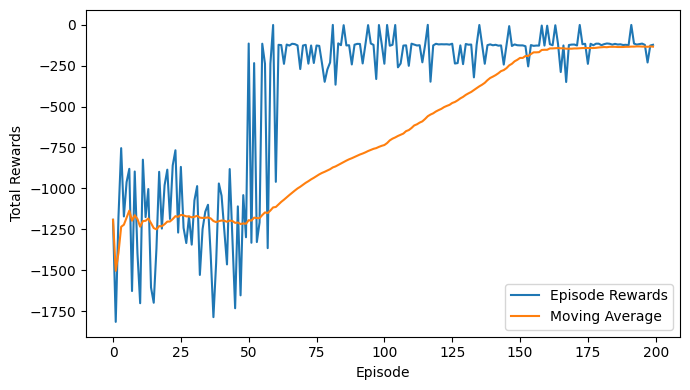

In [8]:
def running_avg(totalrewards):
    N = len(totalrewards)
    totalrewards = np.array(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
    return running_avg

plt.figure(figsize=(7, 4))
plt.plot(returns, label='Episode Rewards')
plt.plot(running_avg(returns), label='Moving Average')
plt.xlabel('Episode')
plt.ylabel('Total Rewards')
plt.legend()
plt.tight_layout()
plt.show()

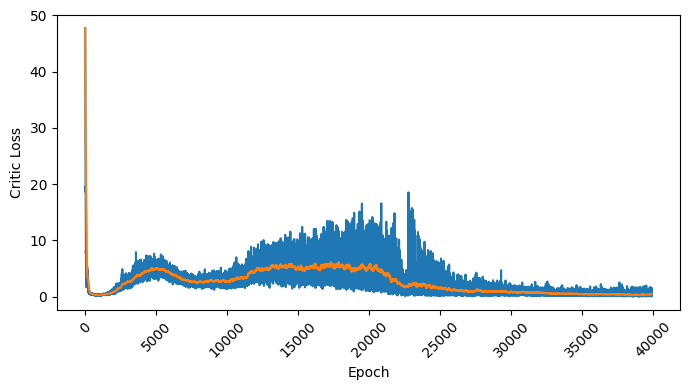

In [9]:
plt.figure(figsize=(7, 4))
plt.plot(critic_losses)
plt.plot(running_avg(np.array(critic_losses)))
plt.xlabel('Epoch')
plt.ylabel('Critic Loss')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

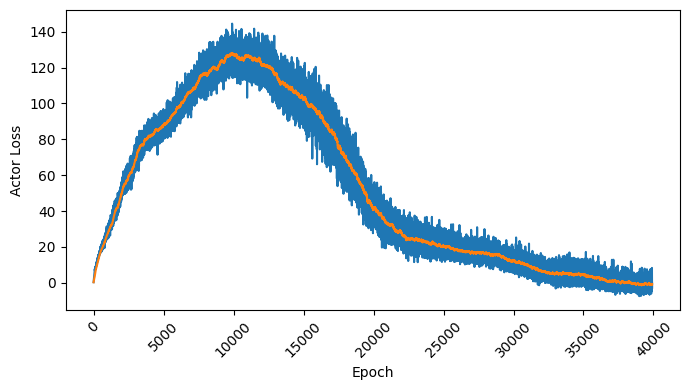

In [10]:
plt.figure(figsize=(7, 4))
plt.plot(actor_losses)
plt.plot(running_avg(np.array(actor_losses)))
plt.xlabel('Epoch')
plt.ylabel('Actor Loss')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Cost-to-go

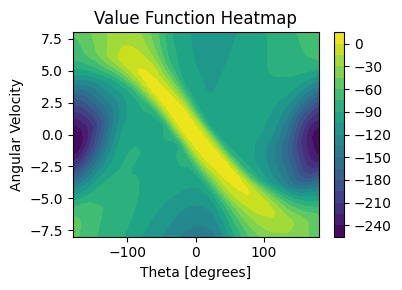

In [11]:
# TODO

## Policy map

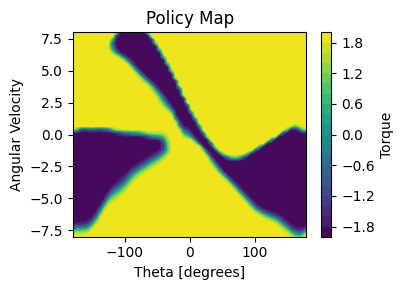

In [12]:
# TODO

## State histogram

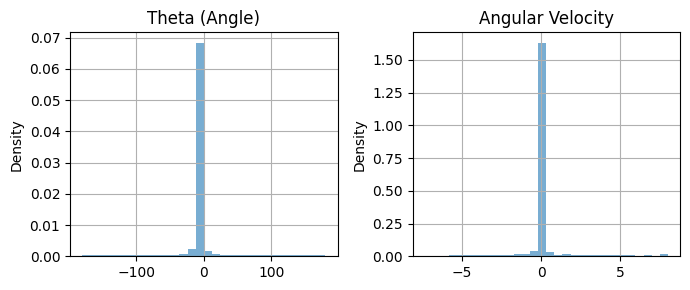

In [13]:
# TODO

## Render the learned policy

In [20]:
from IPython.display import Video, display
import cv2

def render_pendulum(agent):
    num_timesteps = 200
    env = gym.make('Pendulum-v1', render_mode='rgb_array')
    state, _ = env.reset()
    video_path = "DDPG_render.mp4"
    frame_width, frame_height = env.render().shape[1], env.render().shape[0]
    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    out = cv2.VideoWriter(video_path, fourcc, 30, (frame_width, frame_height))
    for _ in range(num_timesteps):
        action = agent.get_action(state, 0)
        state, reward, done, _, _ = env.step(action)
        frame = env.render()
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame_bgr)
    out.release()
    env.close()
    display(Video(video_path))

render_pendulum(agent)